In [15]:
# add autoreload to automatically reload modules after they are modified
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from tqdm import tqdm

import pyroomacoustics as pra
import itertools

import eval_tools as eval

Used the data of experiment 3, but use threshold to find the number of sources.

In [17]:
# load data
exp_df = pd.read_csv('results/experiment_results_exp-3.csv')
# keep only 
exp_df['loc_method_simple'] = exp_df['loc_method'].apply(lambda x: x.split('-')[0])
exp_df = exp_df[
    (exp_df['n_sources'] == 3)
    & (exp_df['seed'] == 13)
    & (exp_df['duration'] == 0.5)
    & (exp_df['loc_method_simple'].isin(['srp_phat', 'music', 'alpha']))
]

# laod picke file with the ground truth
with open('results/experiment_results_exp-3_with_ang_specs.pkl', 'rb') as f:
    ang_specs = pickle.load(f)
    
print(exp_df.shape)
print(len(ang_specs))

doa_grid_rad = np.deg2rad(np.arange(0, 360, 6))

(1260, 29)
5100


In [18]:
print(exp_df['loc_method_simple'].unique())

['music' 'srp_phat' 'alpha']


In [ ]:
ang_specs_dicts = {}
for d in tqdm(ang_specs):
    # if the frame id is not in the dict, add it
    if d['frame_id'] not in ang_specs_dicts:
        ang_specs_dicts[d['frame_id']] = {}
    # add the method id to the frame id
    ang_specs_dicts[d['frame_id']][d['method_id']] = d

100%|██████████| 5100/5100 [00:00<00:00, 318910.93it/s]

alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True
alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_alg_nObs-8_seed-13_norm-True
alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-8_seed-13_norm-True
alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-8_seed-42_norm-True
alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True
alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-16_seed-13_norm-True
alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-16_seed-42_norm-True
alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-16_seed-666_norm-True
alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-32_seed-13_norm-True
alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-32_seed-42_norm-True
alpha-2.0_beta-2_eps-1E-3_iter-500_freqs-[200, 4000]_gp-steerer_nObs-32_seed-666_norm-True
alpha-2.0_beta-2_eps-1E-3_

In [20]:
def detect_peaks(values):
    # make circular
    n_points = len(values)
    val_ext = np.append(values, values[:10])

    # run peak finding
    indexes = pra.doa.detect_peaks(val_ext, show=False) % n_points
    candidates = np.unique(indexes)  # get rid of duplicates, if any
    return candidates

In [7]:
metrics_angular_threshold = 10
thresholds_ang_spec = [0., 0.05, 0.1, 0.2, 0.5, 0.6, 0.8, 0.9]

df_results = pd.DataFrame()

for thr in thresholds_ang_spec:
    
    for frame_id in tqdm(ang_specs_dicts.keys(), desc='Iterating over frames for thr={}'.format(thr)):
        for method_id in ang_specs_dicts[frame_id].keys():
                        
            ang_spec = ang_specs_dicts[frame_id][method_id]['ang_spec']
            
            ang_spec = np.mean(np.array(ang_spec), -1)
            ang_spec = ang_spec / np.max(ang_spec)
            
            # set the threshold
            ang_spec[ang_spec < thr] = 0
            
            # find peaks
            peaks = detect_peaks(ang_spec)     
            
            df_ = pd.DataFrame({
                'frame_id': frame_id,
                "method_id": method_id,
                'thresholds_ang_spec': thr,
                'peaks_locations': peaks.tolist(),
                'peaks_ids' : [f'p{i}' for i in range(len(peaks))],
                'n_peaks': len(peaks)
            })
            df_results = pd.concat([df_results, df_], ignore_index=True)
        
print(len(df_results))

Iterating over frames for thr=0.9: 100%|██████████| 150/150 [00:08<00:00, 18.17it/s]

148989


In [8]:
# merge the results_df with the exp_df on the frame_id and method_id
df_merge = df_results.merge(exp_df, on=['frame_id', 'method_id'])
df_merge[:100].to_csv('asd.csv', index=False)

In [9]:
# for each frame id and method id, get the assorciate data_frame
frame_ids = df_merge['frame_id'].unique()
method_ids = df_merge['method_id'].unique()

metrics_angular_threshold = 15

results_thr_list = []

for frame_id in tqdm(frame_ids, desc='Iterating over frames'):
    for method_id in method_ids:
        
        df_ = df_merge.loc[
            (df_merge['frame_id'] == frame_id) 
            & (df_merge['method_id'] == method_id)
        ]
        
        
        thrs = df_['thresholds_ang_spec'].unique()
        
        for thr in thrs:
            
            n_sources = df_.loc[df_['thresholds_ang_spec'] == thr, 'n_sources'].unique()
            
            assert len(n_sources) == 1
            n_sources = n_sources[0]
            
            estimated_peaks_loc = df_.loc[df_['thresholds_ang_spec'] == thr, 'peaks_locations'].unique()
            estimated_azimuths = np.rad2deg(doa_grid_rad[estimated_peaks_loc])
            target_azimuths = np.rad2deg(df_.loc[df_['thresholds_ang_spec'] == thr, 'doas_ref_az'].unique())
            
            n_estimated = len(estimated_azimuths)
            n_target = len(target_azimuths)
            assert n_target == n_sources
            
            metrics = eval.compute_metrics(estimated_azimuths, target_azimuths, metrics_angular_threshold, np.rad2deg(doa_grid_rad))
            
            if len(target_azimuths) > n_sources:
                print(frame_id)
                print(estimated_azimuths)
                print(target_azimuths)
                print(n_sources)
                print(method_id)
                print(df_.loc[df_['thresholds_ang_spec'] == thr])
                raise ValueError('True positives greater than n_sources')
            
            metrics['frame_id'] = frame_id
            metrics['method_id'] = method_id
            metrics['metrics_angular_threshold'] = metrics_angular_threshold
            metrics['thresholds_ang_spec'] = float(thr)
            
            results_thr_list.append(metrics)
        
df_results_thr_ = pd.DataFrame(results_thr_list)

Iterating over frames: 100%|██████████| 15/15 [00:01<00:00,  7.89it/s]


In [10]:
df_results_thr = df_results_thr_.merge(df_merge, on=['frame_id', 'method_id', 'thresholds_ang_spec'])
df_results_thr[:100].to_csv('asd.csv', index=False)

In [11]:
df_.columns

Index(['frame_id', 'method_id', 'thresholds_ang_spec', 'peaks_locations',
       'peaks_ids', 'n_peaks', 'exp_name', 'time', 'record_id', 'num_srcs',
       'src_ids', 'doas_est_idx', 'doas_ref_idx', 'doas_ref_az', 'doas_est_az',
       'doas_ref_el', 'doas_est_el', 'errors', 'target_doa', 'n_sources',
       'duration', 'snr', 'noise_type', 'add_reverberation', 'mc_seed',
       'loc_method', 'freq_min', 'freq_max', 'sv_method', 'nObs', 'seed',
       'sv_normalization', 'loc_method_simple'],
      dtype='object')

[np.float64(0.9111111111111111), np.float64(0.911111111111111), np.float64(0.911111111111111), np.float64(0.8444444444444443), np.float64(0.5999999999999999), np.float64(0.5555555555555555), np.float64(0.4888888888888888), np.float64(0.4222222222222221)]
[np.float64(0.1128579890904821), np.float64(0.0428625754341206), np.float64(0.030650607822530793), np.float64(0.012716747321808773), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]
[np.float64(0.6444444444444443), np.float64(0.6444444444444443), np.float64(0.6222222222222221), np.float64(0.6222222222222221), np.float64(0.4888888888888889), np.float64(0.4444444444444444), np.float64(0.3555555555555555), np.float64(0.3333333333333333)]
[np.float64(0.10003886598107307), np.float64(0.09400015819026444), np.float64(0.07807412842541828), np.float64(0.0622249507549883), np.float64(0.007124319046150683), np.float64(0.005675043683831842), np.float64(0.004286154794942954), np.float64(0.0028368794326241132)]
[np.float64(0.8666

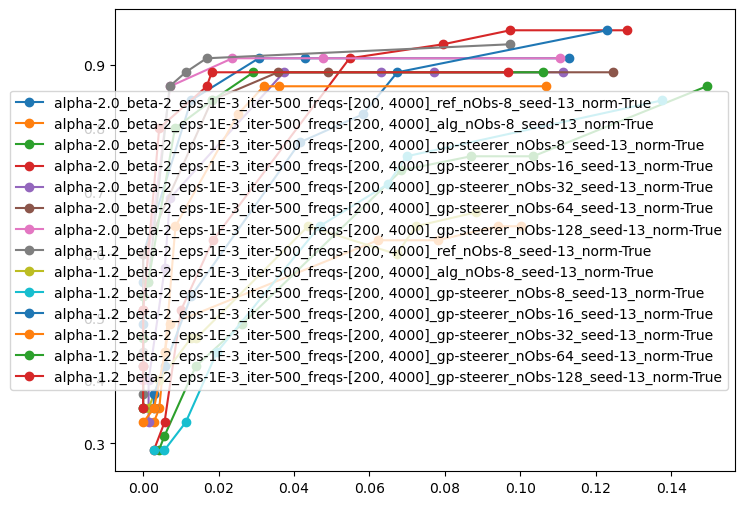

In [14]:
frame_ids = df_results_thr['frame_id'].unique()
method_ids = df_results_thr['method_id'].unique()

plt.figure(figsize=(8, 6))

for method_id in method_ids:

    tpr_list = []
    fpr_list = []
    
    for t, thr in enumerate(thrs):

        tpr_list_ = []
        fpr_list_ = []
        
        for frame_id in frame_ids:
                
            df_ = df_results_thr.loc[
                (df_results_thr['method_id'] == method_id)
                & (df_results_thr['frame_id'] == frame_id)
            ]
            
            thrs = df_['thresholds_ang_spec'].unique()
            
            data_for_roc = []

                
            tpr = np.mean(df_[df_['thresholds_ang_spec'] == thr]['tpr'].values)
            fpr = np.mean(df_[df_['thresholds_ang_spec'] == thr]['fpr'].values)
            peaks_id = df_[df_['thresholds_ang_spec'] == thr]['peaks_ids'].values
            
            assert len(np.unique(tpr)) == len(np.unique(fpr)) == 1
                        
            tpr_list_.append(tpr)
            fpr_list_.append(fpr)
    
        tpr_list.append(np.average(tpr_list_))
        fpr_list.append(np.average(fpr_list_))
                
    print(tpr_list)
    print(fpr_list)
        
    # plot ROC curve
    plt.plot(fpr_list, tpr_list, marker='o', label=method_id)
    
plt.legend()
plt.show()

In [ ]:
df___.to_csv('df_results_thr.csv', index=False)